In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from celluloid import Camera
from pathlib import Path

In [2]:
save_path = Path('save/ising')

sampler_names = {
    'bg-1': 'Gibbs-1',
    'bg-2': 'Gibbs-2',
    'bg-5': 'Gibbs-5',
    'hb-10-1': 'HB-10-1',
    'gwg': 'GWG',
    'gwg-3': 'GWG-3',
    'gwg-5': 'GWG-5'
}

sigmas = np.arange(0.25, 0.51, 0.05)

data = []
for i in range(8):
    for sigma in sigmas:
        sigma = np.round(sigma, 2)
        seed_path = save_path / '10x10' / str(i) / str(sigma) / 'results.pkl'
        with open(seed_path, 'rb') as f:
            results = pickle.load(f)
            for sampler, sampler_name in sampler_names.items():
                ess_values = results['ess'][sampler]
                for ess in ess_values:
                    data.append({
                        'seed': i,
                        'sigma': sigma,
                        'sampler_name': sampler_name,
                        'ess': np.log(ess)
                    })

df_10 = pd.DataFrame(data)
df_10 = df_10.groupby(['sampler_name', 'seed', 'sigma']).mean()

data = []
for i in range(4):
    for sigma in sigmas:
        sigma = np.round(sigma, 2)
        seed_path = save_path / '40x40' / str(i) / str(sigma) / 'results.pkl'
        with open(seed_path, 'rb') as f:
            results = pickle.load(f)
            for sampler, sampler_name in sampler_names.items():
                ess_values = results['ess'][sampler]
                for ess in ess_values:
                    data.append({
                        'seed': i,
                        'sigma': sigma,
                        'sampler_name': sampler_name,
                        'ess': np.log(ess)
                    })

df_40 = pd.DataFrame(data)
df_40 = df_40.groupby(['sampler_name', 'seed', 'sigma']).mean()

try:
    samples = {}
    for sigma in [0.25, 0.35, 0.4, 0.5]:
        with open(save_path / '40x40' / '0' / str(sigma) / 'results.pkl', 'rb') as f:
            results = pickle.load(f)
        samples[sigma] = results['xs']['gwg'][-1].reshape(-1, 40, 40)
    
    videos = {}
    for sigma in [0.25, 0.5]:
        with open(save_path / '40x40' / '0' / str(sigma) / 'results.pkl', 'rb') as f:
            results = pickle.load(f)
        v = {sampler_names[k]: np.array([xs[:4].reshape(4, 40, 40) for xs in results['xs'][k]]) for k in ['bg-1', 'bg-2', 'hb-10-1', 'gwg']}
        videos[sigma] = v
    T, N, H, W = next(iter(v.values())).shape
except:
    print('Missing full results.pkl files.')

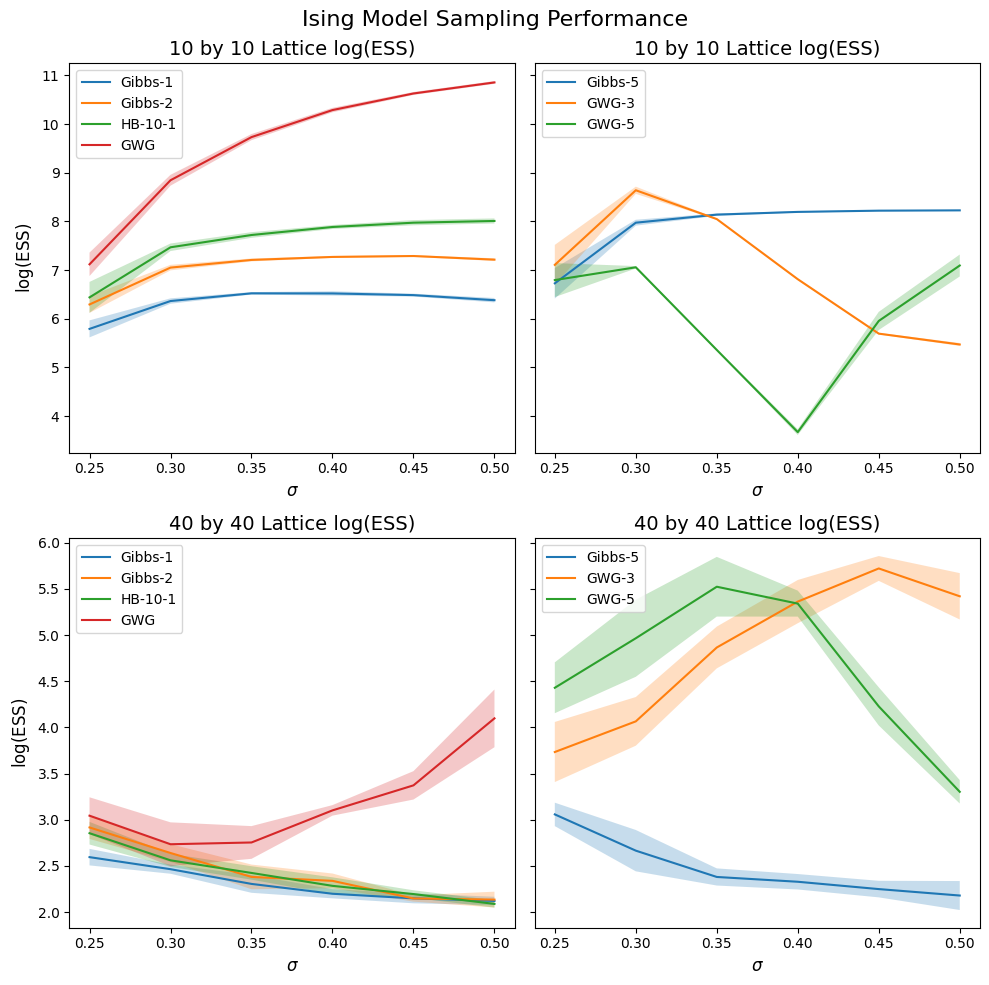

In [3]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey='row')

for i, df in enumerate([df_10, df_40]):

    for j, samplers in enumerate([['Gibbs-1', 'Gibbs-2', 'HB-10-1', 'GWG'], ['Gibbs-5', 'GWG-3', 'GWG-5']]):

        for sampler in samplers:
            
            means = []
            sems = []

            for sigma in sigmas:
                sigma = np.round(sigma, 2)
                ess_vals = df.loc[(sampler, slice(None), sigma), 'ess']
                means.append(ess_vals.mean())
                sems.append(ess_vals.std() / np.sqrt(len(ess_vals)))

            means = np.array(means)
            sems = np.array(sems)
            axs[i, j].plot(sigmas, means, label=sampler)
            axs[i, j].fill_between(sigmas, means - 1.96 * sems, means + 1.96 * sems, alpha=0.25)

            axs[i, j].set_xlabel(r"$\sigma$", fontsize=12)
            if j == 0:
                axs[i, j].set_ylabel(r"$\log(\mathrm{ESS})$", fontsize=12)
            axs[i, j].legend(loc='upper left')

axs[0, 0].set_title('10 by 10 Lattice log(ESS)', fontsize=14)
axs[0, 1].set_title('10 by 10 Lattice log(ESS)', fontsize=14)
axs[1, 0].set_title('40 by 40 Lattice log(ESS)', fontsize=14)
axs[1, 1].set_title('40 by 40 Lattice log(ESS)', fontsize=14)
fig.suptitle('Ising Model Sampling Performance', fontsize=16)
plt.tight_layout()
plt.show()

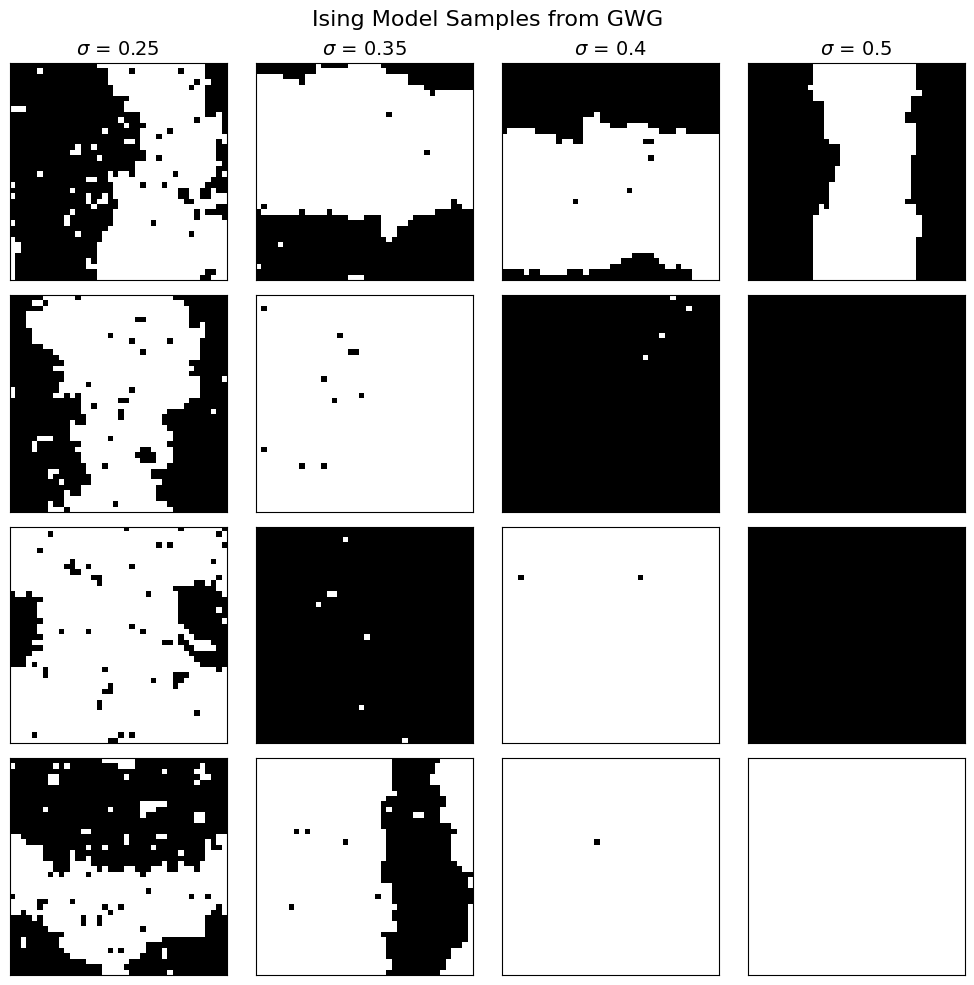

In [4]:
if samples:
    np.random.seed(42)
    
    fig, axs = plt.subplots(4, 4, figsize=(10, 10))
    
    for j, (sigma, xs) in enumerate(samples.items()):
        for i, x in enumerate(xs[np.random.permutation(len(xs))[:4]]):
            ax = axs[i, j]
            ax.imshow(x, cmap='gray', vmin=0, vmax=1)
            if i == 0:
                ax.set_title(f'$\sigma$ = {sigma}', fontsize=14)
            ax.set_xticks([])
            ax.set_yticks([])
    fig.suptitle('Ising Model Samples from GWG', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print('Missing full results.pkl files.')

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


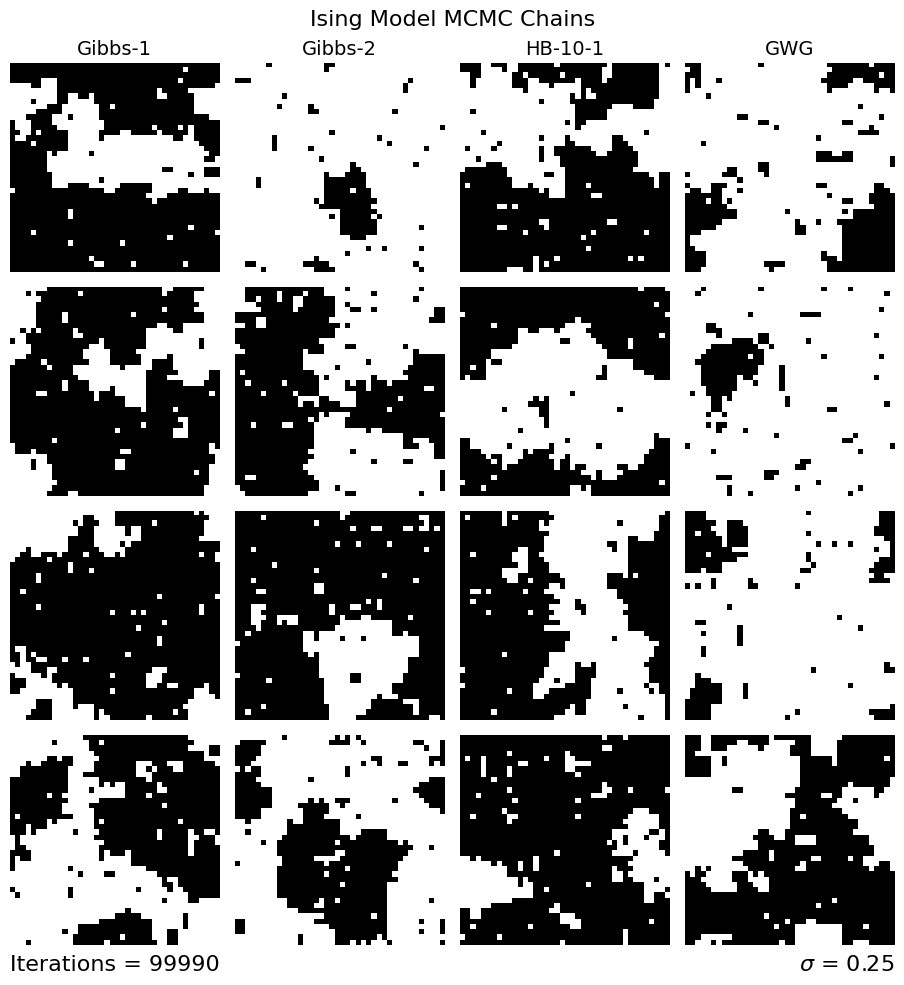

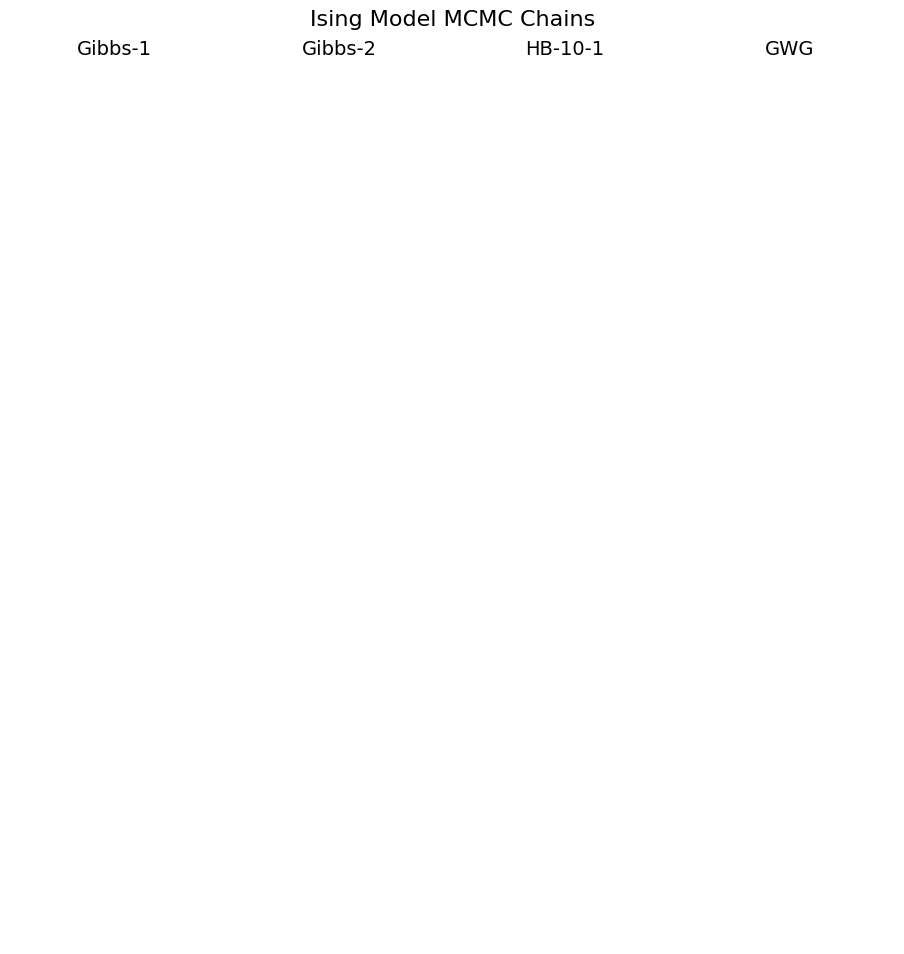

In [5]:
try:
    for sigma, v in videos.items():
    
        fig, axs = plt.subplots(N, len(v), figsize=(10, 10))
    
        camera = Camera(fig)
    
        for t in np.rint(np.linspace(1, np.sqrt(T), 200) ** 2 - 1).astype(int):
            for i in range(N):
                for j, sampler in enumerate(v):
                    ax = axs[i, j]
                    ax.imshow(v[sampler][t, i], cmap='gray', vmin=0, vmax=1)
                    if i == 0:
                        ax.set_title(sampler, fontsize=14)
                    ax.axis('off')
            ax.text(1.0, -0.05, f'$\sigma$ = {sigma}', ha='right', va='top', fontsize=16, transform=ax.transAxes)
            axs[-1, 0].text(0, -0.05, f'Iterations = {10 * t}', ha='left', va='top', fontsize=16, transform=axs[-1, 0].transAxes)
            fig.suptitle('Ising Model MCMC Chains', fontsize=16)
            plt.tight_layout()
            camera.snap()
    
        animation = camera.animate()
        animation.save(f'ising_comparison_sigma_{sigma}.gif', fps=10)
except:
    print('Missing full results.pkl files.')